# Just Object Classification Demo Project
Here you can go through my demo project that uses VGG-like network. This notebook is just given to demonstrate basic concepts of Object Classification and their implementation using Pytorch.

Importing all necessary packages and modules

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from hydra import initialize, compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline

/home/tkoval/.conda/envs/jn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


We will use a common dataset named `CIFAR10` which consists of 60000 32x32 color images that are equally distributed into 10 classes

In [3]:
from torchvision.datasets import CIFAR10

Hyperparamethers stuff:

In [4]:
with initialize(version_base=None, config_path="."):
  config = compose(config_name="config")

Then we need to define train, validation and test datasets in order to use them further. 

First of all, we define some basic transformations to make images suitable for our model.

We also divide our entire dataset into a train and a test subsets while initializing dataset objects. Then we split our train set into train and validation and make all necessary `DataLoader`'s

In [5]:
transform = transforms.Compose(
    [transforms.Resize((56,56)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_set = CIFAR10(root="./data/train", train=True, download=True, transform=transform)
test_set = CIFAR10(root="./data/test", train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


All supporting functions are imported from an `utils.py` module below:

In [2]:
from utils import get_train_val_indices, train, test, get_accuracy, imshow

In [9]:
train_indices, val_indices = get_train_val_indices(config.data.validation_multiplier)
print(len(train_indices))
print(len(val_indices))

40000
10000


In [10]:
train_data = torch.utils.data.DataLoader(
    train_set, 
    batch_size=config.data.batch_size, 
    shuffle=True,
    num_workers=config.data.num_workers
)
val_data = torch.utils.data.DataLoader(
    train_set,
    batch_size=config.data.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers
)
test_data = torch.utils.data.DataLoader(
    test_set,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers
)

Let's preview some images from a train dataset

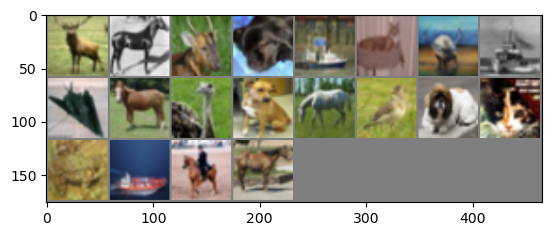

['deer', 'horse', 'deer', 'dog', 'ship', 'cat', 'deer', 'ship', 'plane', 'horse', 'bird', 'dog', 'horse', 'bird', 'dog', 'cat', 'frog', 'ship', 'horse', 'horse']


In [11]:
images, labels = next(iter(train_data))
imshow(torchvision.utils.make_grid(images))
print([classes[i] for i in labels])

We will use `VGG`-like model just because it's complexity allows to easily train it in a small period of time while providing a good enough accuracy for demonstration purposes:

In [3]:
from utils import Net

model = Net()
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [14]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.model.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Main cell that goes through 5 epochs of training process using a CUDA device

In [18]:
config.model.num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train(config.model.num_epochs)
print("Training Finished")

The model will be running on cuda:0 device


 40%|████      | 1003/2500 [00:36<00:52, 28.29it/s]

[1,  1000] loss: 1.588


 80%|████████  | 2005/2500 [01:12<00:17, 28.22it/s]

[1,  2000] loss: 1.209


100%|██████████| 2500/2500 [01:29<00:00, 27.87it/s]


Epoch: 1    Accuracy: 64.968


 40%|████      | 1005/2500 [00:35<00:52, 28.52it/s]

[2,  1000] loss: 1.272


 80%|████████  | 2004/2500 [01:10<00:17, 28.63it/s]

[2,  2000] loss: 0.891


100%|██████████| 2500/2500 [01:27<00:00, 28.61it/s]


Epoch: 2    Accuracy: 73.98


 40%|████      | 1005/2500 [00:35<00:52, 28.55it/s]

[3,  1000] loss: 0.679


 80%|████████  | 2004/2500 [01:10<00:17, 28.63it/s]

[3,  2000] loss: 0.654


100%|██████████| 2500/2500 [01:27<00:00, 28.60it/s]


Epoch: 3    Accuracy: 82.29


 40%|████      | 1005/2500 [00:35<00:52, 28.53it/s]

[4,  1000] loss: 0.496


 80%|████████  | 2004/2500 [01:10<00:17, 28.60it/s]

[4,  2000] loss: 0.476


100%|██████████| 2500/2500 [01:27<00:00, 28.56it/s]


Epoch: 4    Accuracy: 87.704


 40%|████      | 1005/2500 [00:35<00:52, 28.49it/s]

[5,  1000] loss: 0.308


 80%|████████  | 2004/2500 [01:10<00:17, 28.56it/s]

[5,  2000] loss: 0.318


100%|██████████| 2500/2500 [01:27<00:00, 28.54it/s]


Epoch: 5    Accuracy: 94.696
Training Finished


After training, we get 94,5% accuracy on a validation set, but of course we still need some testing

In [19]:
model = Net()
model.load_state_dict(torch.load("./model.pth"))
model.eval()
test()

80.4


`80%` accuracy on a test dataset. So far so good, since we used a very light model and performed only 5 epochs of training. 

Thank you!